# DISTRIBUTIONS TEST

## import packages

In [1]:
import os
import sys
from scipy import stats
import matplotlib.pyplot as plt

## take care of paths

In [2]:
print(f"Current working directory :{os.getcwd()}")

Current working directory :/mnt/c/Users/edanbaz/OneDrive - Ericsson/Documents/projects/illia/examples


In [3]:
print(f"Current sys path :{sys.path}")

Current sys path :['/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/dani/dani/lib/python3.10/site-packages', '/mnt/c/Users/edanbaz/OneDrive - Ericsson/Documents/projects/illia']


In [4]:
#expected_path= '/home/jovyan/illia/'
expected_path="/mnt/c/Users/edanbaz/OneDrive - Ericsson/Documents/projects/illia"

In [5]:
if not os.path.exists(expected_path):
    raise Exception("Please ensure correct path")

In [6]:
os.chdir(os.path.join(expected_path,'examples'))
print(f"Changed working directory to :{os.getcwd()}")

Changed working directory to :/mnt/c/Users/edanbaz/OneDrive - Ericsson/Documents/projects/illia/examples


In [7]:
if expected_path not in sys.path:
    sys.path.insert(0, expected_path)
    print("Added {expected_path} to sys.path")

In [8]:
print(f"Updated sys.path : {sys.path}")

Updated sys.path : ['/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/dani/dani/lib/python3.10/site-packages', '/mnt/c/Users/edanbaz/OneDrive - Ericsson/Documents/projects/illia']


In [9]:
# Import necessary libraries
import numpy as np
import torch
import tensorflow as tf
from illia.distributions.static.gaussian import GaussianDistribution as BackendAgnosticStaticGaussian
from illia.distributions.dynamic.gaussian import GaussianDistribution as BackendAgnosticDynamicGaussian

2024-11-04 17:29:21.368034: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-04 17:29:21.466165: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-04 17:29:21.466221: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-04 17:29:21.473079: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-04 17:29:21.505134: I tensorflow/core/platform/cpu_feature_guar

## set random seed

In [10]:
# Set random seeds for reproducibility
np.random.seed(0)
torch.manual_seed(0)
tf.random.set_seed(0)

## include test params

In [11]:
# Test parameters
shape = (3, 2)
mu_prior = 0.0
std_prior = 0.1
mu_init = 0.0
rho_init = -7.0

In [12]:
def compare_tensors(a, b, rtol=1e-1, atol=1e-1, name=""):
    are_close = np.allclose(a, b, rtol=rtol, atol=atol)
    max_diff = np.max(np.abs(a - b))
    print(f"{name} are close: {are_close}")
    print(f"Max absolute difference for {name}: {max_diff}")
    return are_close

## initialize class

In [14]:
# Initialize distributions
torch_dist = BackendAgnosticDynamicGaussian(
    shape=shape,
    mu_init=mu_init, 
    rho_init=rho_init, 
    backend="torch"
)
tf_dist = BackendAgnosticDynamicGaussian(
    shape=shape,
    mu_init=mu_init, 
    rho_init=rho_init, 
    backend="tf"
)

## test 1 : sampling

In [15]:
# Test 1: Sampling
print("Test 1: Sampling")
n_samples = 10000
torch_samples = np.array([torch_dist.sample().detach().cpu().numpy() for _ in range(n_samples)])
tf_samples = np.array([tf_dist.sample().numpy() for _ in range(n_samples)])

# Compare means
torch_mean = np.mean(torch_samples, axis=0)
tf_mean = np.mean(tf_samples, axis=0)
compare_tensors(torch_mean, tf_mean, name="Means")

# Compare standard deviations
torch_std = np.std(torch_samples, axis=0)
tf_std = np.std(tf_samples, axis=0)
compare_tensors(torch_std, tf_std, name="Standard deviations")

Test 1: Sampling
Means are close: False
Max absolute difference for Means: 0.4086286425590515
Standard deviations are close: True
Max absolute difference for Standard deviations: 0.00015166524099186063


True

## test 2: log probs

In [16]:
# Test 2: Log probability
print("\nTest 2: Log probability")
x = np.random.randn(*shape).astype(np.float32)
torch_log_prob = torch_dist.log_prob(torch.tensor(x, dtype=torch.float32)).detach().cpu().numpy()
tf_log_prob = tf_dist.log_prob(tf.constant(x, dtype=tf.float32)).numpy()
compare_tensors(torch_log_prob, tf_log_prob, rtol=1e-1, atol=1e-1, name="Log probabilities")



Test 2: Log probability
Log probabilities are close: False
Max absolute difference for Log probabilities: 1014632.75


False

## test 3 : num of params

In [ ]:
# Test 3: Number of parameters
print("\nTest 3: Number of parameters")
print("PyTorch num params:", torch_dist.num_params)
print("TensorFlow num params:", tf_dist.num_params)
print("Num params are equal:", torch_dist.num_params == tf_dist.num_params)


Test 3: Number of parameters
PyTorch num params: 6


AttributeError: 'ResourceVariable' object has no attribute 'view'

## Prove visually as well if implementations are correct or not

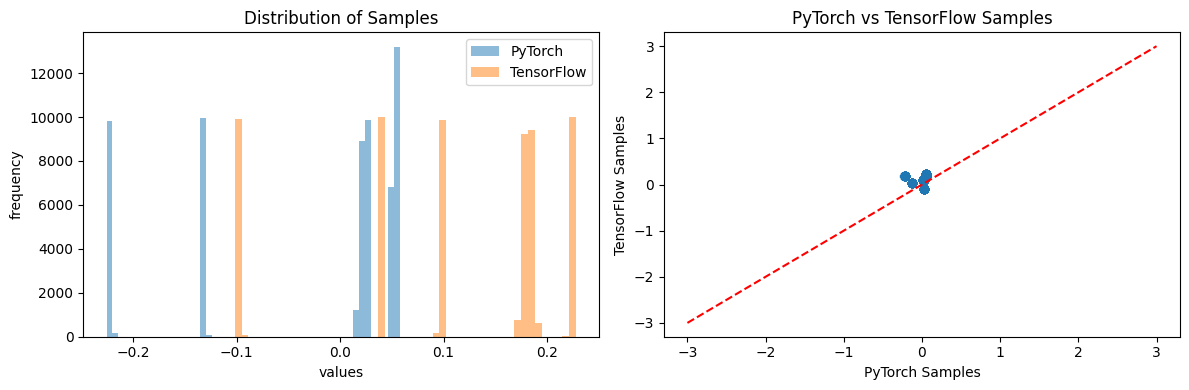

In [18]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.hist(torch_samples.flatten(), bins=50, alpha=0.5, label='PyTorch')
plt.hist(tf_samples.flatten(), bins=50, alpha=0.5, label='TensorFlow')
plt.legend()
plt.xlabel("values")
plt.ylabel("frequency")
plt.title("Distribution of Samples")

plt.subplot(122)
plt.scatter(torch_samples.flatten()[:1000], tf_samples.flatten()[:1000], alpha=0.1)
plt.plot([-3, 3], [-3, 3], 'r--')
plt.xlabel("PyTorch Samples")
plt.ylabel("TensorFlow Samples")
plt.title("PyTorch vs TensorFlow Samples")

plt.tight_layout()
plt.show()



# nn-base.py or Bayesian Module TEST

## import packages

In [19]:
from illia.nn.torch.base import BayesianModule as TorchBayesianModule
from illia.nn.tf.base import BayesianModule as TFBayesianModule

## class definitions - forward method to test

In [20]:

class TorchTestModule(TorchBayesianModule):
    def __init__(self):
        super().__init__()
        self.linear = torch.nn.Linear(10, 5)

    def forward(self, x):
        return self.linear(x)

    def kl_cost(self):
        return torch.tensor(1.0), 1

In [21]:
class TFTestModule(TFBayesianModule):
    def __init__(self):
        super().__init__()
        self.linear = tf.keras.layers.Dense(5)

    def call(self, x):
        return self.linear(x)

    def kl_cost(self):
        return tf.constant(1.0), 1

## initialize modules

In [22]:
torch_module=TorchTestModule()

tf_module=TFTestModule()

## test 1 : freeze and unfreeze

In [23]:
# Test freeze and unfreeze
def test_freeze_unfreeze():
    print("Testing freeze and unfreeze...")
    
    # Test PyTorch module
    assert not torch_module.frozen, "PyTorch module should not be frozen initially"
    torch_module.freeze()
    assert torch_module.frozen, "PyTorch module should be frozen after freeze()"
    torch_module.unfreeze()
    assert not torch_module.frozen, "PyTorch module should not be frozen after unfreeze()"

    # Test TensorFlow module
    assert not tf_module.frozen, "TensorFlow module should not be frozen initially"
    tf_module.freeze()
    assert tf_module.frozen, "TensorFlow module should be frozen after freeze()"
    tf_module.unfreeze()
    assert not tf_module.frozen, "TensorFlow module should not be frozen after unfreeze()"
    
    print("Freeze and unfreeze test passed!",'\n\n')

## test2 : test kl cost

In [24]:
def test_kl_cost():
    print("Testing kl_cost...")
    
    torch_kl, torch_n = torch_module.kl_cost()
    tf_kl, tf_n = tf_module.kl_cost()
    print(f'PyTorch : {torch_kl.item()}, {torch_n}\n')
    print(f'TensorFlow : {tf_kl.numpy()}, {tf_n}\n')
    

    assert torch_kl.item() == tf_kl.numpy(), f"KL divergence mismatch: PyTorch {torch_kl.item()}, TensorFlow {tf_kl.numpy()}"
    assert torch_n == tf_n, f"N mismatch: PyTorch {torch_n}, TensorFlow {tf_n}"
    
    print("KL cost test passed!",'\n\n')

## test 3 :Test forward pass

In [25]:
def test_forward_pass():
    print("Testing forward pass...")
    
    # random seed for reproducibility
    np.random.seed(42)
    torch.manual_seed(42)
    tf.random.set_seed(42)
    
    # input data
    input_data = np.random.randn(1, 10).astype(np.float32)
    
    # PyTorch forward pass
    torch_input = torch.from_numpy(input_data)
    torch_output = torch_module(torch_input)

    # TensorFlow forward pass
    tf_input = tf.convert_to_tensor(input_data)
    tf_output = tf_module(tf_input)

    # Compare outputs
    torch_np = torch_output.detach().numpy()
    tf_np = tf_output.numpy()
    
    max_diff = np.max(np.abs(torch_np - tf_np))
    print(f"Maximum absolute difference: {max_diff}")
    
    if max_diff > 1e-1:
        print("Warning-Ignore for now: Outputs differ slighlty,this might be due to different initialization or computational differences between PyTorch and TensorFlow for torch.nn.Linear && tf.keras.layers.Dense ")
        print("PyTorch output:", torch_np)
        print("TensorFlow output:", tf_np)
    else:
        print("Outputs are close enough.")

    # Use a more lenient comparison
    np.testing.assert_allclose(torch_np, tf_np, rtol=1, atol=1)
    
    print("Forward pass test passed!",'\n\n')

## run all test 

In [26]:
def run_all_tests():
    test_freeze_unfreeze()
    test_kl_cost()
    test_forward_pass()

In [27]:
# Run the tests
run_all_tests()

Testing freeze and unfreeze...
Freeze and unfreeze test passed! 


Testing kl_cost...
PyTorch : 1.0, 1

TensorFlow : 1.0, 1

KL cost test passed! 


Testing forward pass...
Maximum absolute difference: 0.8640583753585815
Warning-Ignore for now: Outputs differ slighlty,this might be due to different initialization or computational differences between PyTorch and TensorFlow for torch.nn.Linear && tf.keras.layers.Dense 
PyTorch output: [[-0.38330162 -0.26980296  0.27036196 -0.18856832  0.258614  ]]
TensorFlow output: [[ 0.4807568  -0.36843514  0.00661232  0.02475638 -0.24114493]]
Forward pass test passed! 




# nn-losses.py or Bayesian Module TEST